In [ ]:
import math

import contextily as cx
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from shapely import Point
from sklearn.preprocessing import minmax_scale

with open("../data/crs.yaml", "r") as fp:
    crs = yaml.safe_load(fp)
with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)

In [38]:
CITY = "madrid"
CMAP = "RdYlBu_r"

In [ ]:
data = pd.read_csv(f"../output/{CITY}/merged.csv")
data["geometry"] = data.apply(lambda x: Point(x["stop_lon"], x["stop_lat"]), axis=1)
data = gpd.GeoDataFrame(data, geometry="geometry", crs=4326)

,stop_id,area,ellipticity,distance_from_largest_betweenness_centroid,distance_from_largest_betweenness_medoid,distance_from_landuse_centroid,cultural_institutions_multimodal,drugstores_multimodal,groceries_multimodal,healthcare_multimodal,...,services_walk15,eigenvector_centrality,degree_centrality,closeness_centrality,betweenness_centrality,cluster,stop_lat,stop_lon,stop_name,geometry
0,5130,1.977,0.8803,9.661,9.659,7.072,0,10,5,0,...,11,0.000003,0.001158,0.061367,0.006125,3,40.50730,-3.68606,Monasterio De Arlanza - Nuestra Señora De Valv...,POINT (-3.68606 40.5073)
1,5166,1.977,0.8803,9.700,9.698,7.111,0,10,5,0,...,11,0.000003,0.001158,0.061367,0.006125,3,40.50767,-3.68597,Monasterio De Arlanza - Nuestra Señora De Valv...,POINT (-3.68597 40.50767)
2,3881,1.984,0.5615,10.242,10.244,7.643,0,5,3,1,...,9,0.000014,0.002703,0.065333,0.016070,690,40.51320,-3.67918,Carretera De Alcobendas - Bercianos,POINT (-3.67918 40.5132)


In [47]:
boundary = gpd.read_file(f"../output/{CITY}/boundary.geojson").to_crs(crs[CITY])
boundary_polygon = boundary.geometry[0]

In [50]:
to_plot_el = data.sort_values("ellipticity", ascending=True).to_crs(crs[CITY])

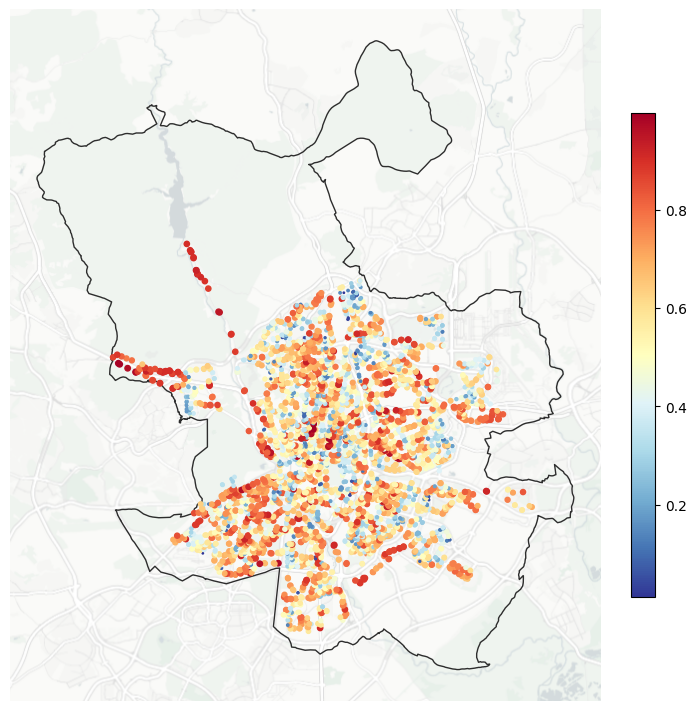

In [57]:
fig, ax = plt.subplots(figsize=(7, 7), layout="constrained")
boundary.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, boundary_polygon).plot(
    column="ellipticity",
    legend=True,
    legend_kwds={"shrink": 0.7},
    markersize=minmax_scale(
        gpd.clip(to_plot_el, boundary_polygon)["ellipticity"], feature_range=(1, 16)
    ),
    cmap=CMAP,
    ax=ax,
)
cx.add_basemap(
    ax,
    crs=crs[CITY],
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
ax.axis("off")
ax.margins(0)
for i in ["png"]:
    fig.savefig(
        f"../output/{CITY}/ellipticity.{i}",
        dpi=300,
        facecolor="white",
        bbox_inches="tight",
        # pad_inches=0.1,
        metadata=config["metadata"][i],
    )

In [34]:
bins = jenkspy.jenks_breaks(
    to_plot_el.query("ellipticity.notna()")["ellipticity"], n_classes=6
)
bins

[0.0099, 0.1877, 0.3003, 0.4071, 0.5142, 0.6369, 0.9014]

In [ ]:
minx, miny, maxx, maxy = boundary_polygon.bounds
diff_y = maxy - miny
diff_x = maxx - minx
offset = abs(diff_y - diff_x) / 2
if diff_y >= diff_x:
    minx -= offset
    maxx += offset
else:
    miny -= offset
    maxy += offset

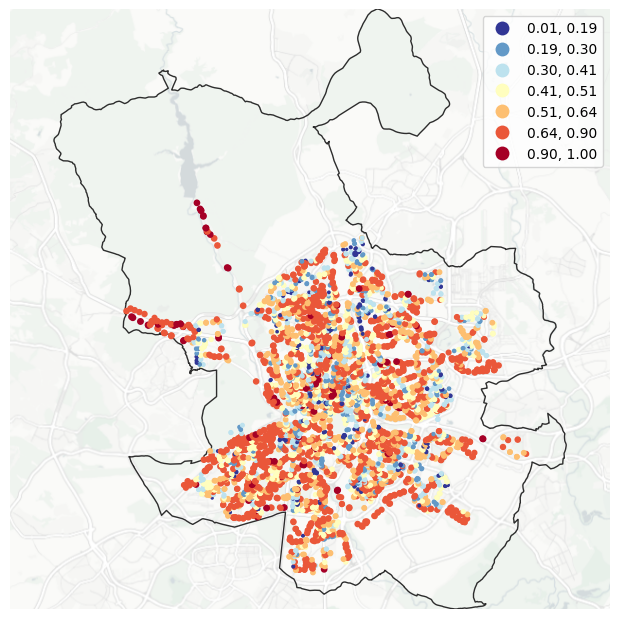

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
ax.set_xlim([math.floor(minx), math.ceil(maxx)])
ax.set_ylim([math.floor(miny), math.ceil(maxy)])
boundary.plot(ax=ax, fc="none", ec="#2d2d2d")
gpd.clip(to_plot_el, boundary_polygon).query("ellipticity.notna()").plot(
    column="ellipticity",
    legend=True,
    cmap=CMAP,
    ax=ax,
    scheme="UserDefined",
    classification_kwds=dict(
        bins=bins[1:],
    ),
    markersize=minmax_scale(
        gpd.clip(to_plot_el, boundary_polygon).query("ellipticity.notna()")[
            "ellipticity"
        ],
        feature_range=(2, 16),
    ),
)
ax.margins(0.1)
ax.axis("off")
cx.add_basemap(
    ax,
    crs=crs[CITY],
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)
for i in ["png"]:
    fig.savefig(
        f"../output/{CITY}/ellipticity_jenks.{i}",
        dpi=300,
        facecolor="white",
        pad_inches=0,
        metadata=config["metadata"][i],
    )